In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.distributions.cauchy import Cauchy
from torch.distributions.exponential import Exponential
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
import numpy as np


In [3]:
def skew_gaussian(a,x):
    data= skewnorm.rvs(a, size=x)
    return data
    

In [4]:
Series_Length = 100
data_mean = 5
data_stddev = 0.5


In [5]:
g_input_size = Series_Length  
g_hidden_size = 150  
g_output_size = 30

In [6]:
d_input_size = g_output_size
d_hidden_size = 75   
d_output_size = 1

In [7]:
d_minibatch_size = 15 
g_minibatch_size = 10

num_epochs = 300000
print_interval = 1000

In [8]:
d_learning_rate = 3e-3
g_learning_rate = 8e-3

In [9]:
def get_real_sampler(mu, sigma):
    dist = Normal( mu, sigma )
    return lambda m, n: dist.sample( (m, n) ).requires_grad_()

def get_noise_sampler():
    return lambda m, n: torch.rand(m, n).requires_grad_()  # Uniform-dist data into generator, _NOT_ Gaussian

#actual_data = get_real_sampler( data_mean, data_stddev )
noise_data  = get_noise_sampler()

In [10]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, hidden_size)
        self.map4 = nn.Linear(hidden_size, hidden_size)
        self.map5 = nn.Linear(hidden_size, output_size)
       
              
        
        
        

        self.xfer = torch.nn.SELU()
        self.xfer_2 = torch.nn.SiLU()

    def forward(self, x):
        x = self.xfer( self.map1(x) )
        x = self.xfer( self.map2(x) )
        x = self.xfer( self.map3(x) )
        x = self.xfer( self.map4(x) )
      
      
     
       
        
    
        return self.xfer_2( self.map5( x ) )

In [11]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, hidden_size)
        self.map4 = nn.Linear(hidden_size, output_size)
        

        
        
        
       
        self.elu = torch.nn.ELU()

    def forward(self, x):
        x = self.elu(self.map1(x))
        x = self.elu(self.map2(x))
        x = self.elu(self.map3(x))
        
        
        
        
        
        return torch.sigmoid( self.map4(x) )

In [12]:
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_size, hidden_size=d_hidden_size, output_size=d_output_size)

In [13]:
criterion = nn.BCELoss()
d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate ) #, betas=optim_betas)
g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate ) #, betas=optim_betas)

In [14]:
def train_D_on_actual() :
    #if symmetric gaussian use inbuilt python tensor
    u = d_minibatch_size*d_input_size
    actual_data = skew_gaussian(7,u)
    real_data = torch.Tensor(actual_data)
    real_data = real_data.reshape(d_minibatch_size,d_input_size)
    decision = D( real_data )
    real_labels = torch.ones( d_minibatch_size, 1 )
    error = criterion( decision, real_labels)  # ones = true
    error.backward() 
    return error

In [15]:
def train_D_on_generated() :
    noise = noise_data( d_minibatch_size, g_input_size )
    
    
    fake_data = G( noise ) 
    decision = D( fake_data )
    error = criterion( decision, torch.zeros( d_minibatch_size, 1 ))  # zeros = fake
    error.backward()
    return error

In [16]:
def train_G():
    noise = noise_data( g_minibatch_size, g_input_size )
    fake_data = G( noise )
    fake_decision = D( fake_data )
    error = criterion( fake_decision, torch.ones( g_minibatch_size, 1 ) )  # we want to fool, so pretend it's all genuine

    error.backward()
    return error.item(), fake_data

In [17]:
generator_losses = []
discriminator_losses = []
Generated_samples = []
G_ = np.empty([2000,200])


for epoch in range(num_epochs):
    D.zero_grad()
    
    real_error = train_D_on_actual()
    
    fake_error = train_D_on_generated()
    #print((fake_error.detach().item()+real_error.detach().item())/2)
    d_optimizer.step()
    
    
    G.zero_grad()
    loss,generated = train_G()
    g_optimizer.step()
    discriminator_losses.append((fake_error.detach().item()+real_error.detach().item())/2)
    generator_losses.append( loss )
    if epoch >= 250000 and epoch % 5 ==0:
        Generated_samples.append(generated.flatten().tolist())
        
    
    if( epoch % print_interval) == (print_interval-1) :
        print( "Epoch %6d. Loss %5.3f" % ( epoch+1, loss ) )
        
print("Training complete")

Epoch   1000. Loss 0.716
Epoch   2000. Loss 0.692
Epoch   3000. Loss 0.649
Epoch   4000. Loss 0.708
Epoch   5000. Loss 0.719
Epoch   6000. Loss 0.663
Epoch   7000. Loss 0.697
Epoch   8000. Loss 0.752
Epoch   9000. Loss 0.687
Epoch  10000. Loss 0.701
Epoch  11000. Loss 0.702
Epoch  12000. Loss 0.721
Epoch  13000. Loss 0.708
Epoch  14000. Loss 0.672
Epoch  15000. Loss 0.747
Epoch  16000. Loss 0.727
Epoch  17000. Loss 0.677
Epoch  18000. Loss 0.687
Epoch  19000. Loss 0.695
Epoch  20000. Loss 0.709
Epoch  21000. Loss 0.707
Epoch  22000. Loss 0.696
Epoch  23000. Loss 0.679
Epoch  24000. Loss 0.692
Epoch  25000. Loss 0.688
Epoch  26000. Loss 0.701
Epoch  27000. Loss 0.679
Epoch  28000. Loss 0.732
Epoch  29000. Loss 0.709
Epoch  30000. Loss 0.716
Epoch  31000. Loss 0.676
Epoch  32000. Loss 0.705
Epoch  33000. Loss 0.661
Epoch  34000. Loss 0.687
Epoch  35000. Loss 0.710
Epoch  36000. Loss 0.689
Epoch  37000. Loss 0.735
Epoch  38000. Loss 0.683
Epoch  39000. Loss 0.706
Epoch  40000. Loss 0.663


In [24]:
Generated_samples = []
for i in range(20000):
    noise = noise_data( g_minibatch_size, g_input_size )
    fake_data = G( noise )
    Generated_samples.append(fake_data.flatten().tolist())
    
V = np.empty([20000,200])
for i in range(len(Generated_samples)):
    V[i] = Generated_samples[i]

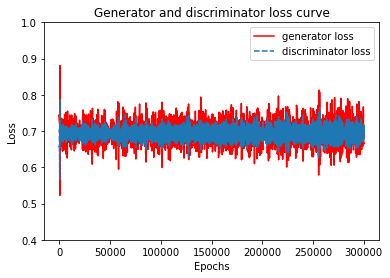

In [34]:
plt.plot(np.linspace(0,300000,300000), generator_losses, 'r', label='generator loss')
plt.plot(np.linspace(0,300000,300000), discriminator_losses, '--', label='discriminator loss')
#plt.plot(np.linspace(0,5000,5000),np.full((5000),0.5), '--')
plt.ylim(0.4,1)
plt.title('Generator and discriminator loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
V = np.empty([10000,300])
for i in range(len(Generated_samples)):
    V[i] = Generated_samples[i]

In [19]:
Generated_samples = []
for i in range(50000):
    noise = noise_data( g_minibatch_size, g_input_size )
    fake_data = G( noise )
    Generated_samples.append(fake_data.flatten().tolist())

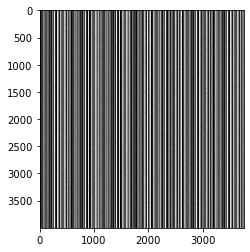

In [20]:
import pylab as plt
import numpy as np

Z =  torch.Tensor(Generated_samples).reshape(1,-1).reshape(4000,3750)
plt.imshow(Z, cmap='gray', interpolation='nearest')
plt.show()

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,   9271.,  23116.,  43345.,  65813.,
         78888.,  99721., 110810., 120453., 119838., 121121., 119928.,
        122593., 124101., 121960., 117084., 112016., 110777., 109649.,
        105184.,  99076.,  92695.,  86608.,  81916.,  78116.,  73715.,
         67145.,  60687.,  55936.,  52284.,  49437.,  45983.,  41406.,
         35473.,  31585.,  28418.,  24401.,  21352.,  19345.,  17687.,
         15943.,  13866.,  11441.,   9312.,   7827.,   6753.,   6025.,
          5437.,   4535.,   3677.,   3034.,   2471.,   2120.,   1786.,
      

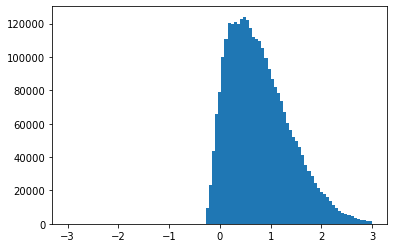

In [89]:
plt.hist(V.flatten().tolist(),np.linspace(-3,3,100))

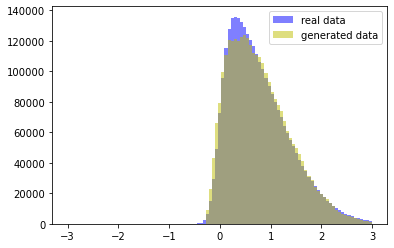

In [90]:
from matplotlib import pyplot
pyplot.hist(skew_gaussian(7,10000*300),np.linspace(-3,3,100),alpha = 0.5, color = 'b', label = 'real data')
pyplot.hist(V.flatten().tolist(),np.linspace(-3,3,100),alpha = 0.5, color = 'y',label = 'generated data')
pyplot.legend(loc='upper right')
pyplot.show()

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+01,
        4.40000e+01, 2.42000e+02, 1.06500e+03, 3.85400e+03, 1.21930e+04,
        3.27480e+04, 7.35270e+04, 1.43694e+05, 2.43364e+05, 3.62391e+05,
        4.80039e+05, 5.76622e+05, 6.40360e+05, 6.71753e+05, 6.79972e+05,
        6.74300e+05, 6.62886e+05, 6.44180e+05, 6.25789e+05, 6.04661e+05,
        5.80357e+05, 5.56542e+05, 5.32361e+05, 5.05700e+05, 4.79122e+05,
        4.52683e+05, 4.26345e+05, 4.00314e+05, 3.74

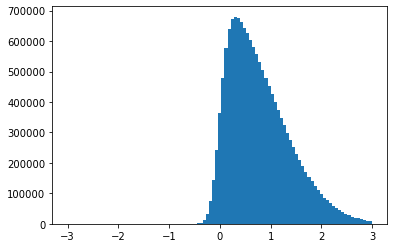

In [26]:
plt.hist(skew_gaussian(7,49999*300),np.linspace(-3,3,100))

In [50]:
moment(skew_gaussian(7,10000),moment=5)

0.7149670247122301

In [ ]:
a = plt.hist(v.flatten().tolist(),np.linspace(2.2,3.7,100))

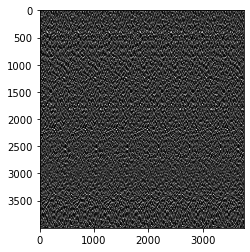

In [68]:
import pylab as plt
import numpy as np

Z =  V.reshape(1,-1).reshape(4000,3750)
plt.imshow(Z, cmap='gray', interpolation='nearest')
plt.show()

In [54]:
from scipy.stats import wasserstein_distance
wasserstein_distance(skew_gaussian(7,49999*300),skew_gaussian(7,49999*300))


0.00028965026588874024

In [ ]:
from scipy import stats
stats.ks_2samp(G.reshape(1,-1).flatten(),actual_data(4999,300).detach().reshape(1,-1).flatten())

In [ ]:
import scipy
scipy.stats.anderson_ksamp([G.reshape(1,-1).flatten(),actual_data(4999,300).detach().reshape(1,-1).flatten()])

In [46]:
from statsmodels.sandbox.stats.runs import runstest_1samp 

In [67]:
runstest_1samp(V.reshape(1,-1)[:,:10000].flatten(),correction = False)

(-1.1848070355150726, 0.2360937502413405)